#  Image Classification of potato disease using ResNet50

This notebook demonstrates how to build and train an image classification model using the ResNet50 architecture, pre-trained on ImageNet, and fine-tune it for a custom dataset. The model is trained to classify images into three categories. We also implement techniques to mitigate overfitting and improve model performance.


In [ ]:
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from keras.models import Sequential
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras import layers
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from glob import glob
import cv2 as cv
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from keras.models import load_model
from tensorflow.keras.regularizers import l2


## Data Loading and Preprocessing


**Custom Data Generator for Image Classification**

This code defines a custom data generator class CustomDataGenerator that inherits from Keras' Sequence. The generator is designed to handle loading and preprocessing images in batches for training, validation, and testing of a neural network model. Below is a detailed explanation of each component, including comments that clarify the logic.

In [96]:
class CustomDataGenerator(Sequence):
    def __init__(self, directory, classes, batch_size=32, target_size=(128, 128), shuffle=True, subset=None, data_fraction=1.0):
        self.directory = directory
        self.classes = classes
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.subset = subset  # 'training', 'validation', or 'testing'
        self.data_fraction = data_fraction  # Fraction of data to use
        
        # Collect all filenames and labels
        self.filenames, self.labels = self.collect_filenames_labels()

        # Apply data fraction
        if 0 < self.data_fraction < 1.0:
            self.filenames, self.labels = self.apply_data_fraction(self.data_fraction, self.filenames, self.labels)
        
        # Split data based on the subset
        self.filenames, self.labels = self.split_data()
        
        self.indexes = np.arange(len(self.filenames))
        self.samples = len(self.filenames)  # Add total number of samples (images)
        
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
        # Debug information: Check collected data
        print(f"Subset: {self.subset}")
        print(f"Collected {len(self.filenames)} images for {self.subset}.")
        print(f"First 5 filenames: {self.filenames[:5]}")
        print(f"First 5 labels: {self.labels[:5]}")

    def collect_filenames_labels(self):
        """Collect filenames and their corresponding labels."""
        filenames = []
        labels = []
        
        # Check if the base directory exists
        if not os.path.exists(self.directory):
            raise ValueError(f"Base directory {self.directory} does not exist!")
        
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.directory, class_name)  # Directory for each class
            if os.path.exists(class_dir):
                class_files = os.listdir(class_dir)
                for filename in class_files:
                    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                        full_path = os.path.join(class_dir, filename)
                        filenames.append(full_path)  # Append full path
                        labels.append(class_idx)  # Append the class index
        return filenames, labels

    def apply_data_fraction(self, fraction, filenames, labels):
        """Apply the fraction to select a subset of the data."""
        unique_labels = np.unique(labels)
        selected_filenames = []
        selected_labels = []
        
        for label in unique_labels:
            class_filenames = [f for f, l in zip(filenames, labels) if l == label]
            n_samples = int(len(class_filenames) * fraction)
            selected_class_filenames = np.random.choice(class_filenames, n_samples, replace=False)
            selected_filenames.extend(selected_class_filenames)
            selected_labels.extend([label] * n_samples)
        
        return selected_filenames, selected_labels

    def split_data(self):
        """Split the data into training, validation, and testing subsets (80%/10%/10%)."""
        train_filenames, temp_filenames, train_labels, temp_labels = train_test_split(
            self.filenames, self.labels, test_size=0.2, stratify=self.labels, random_state=42)
        
        val_filenames, test_filenames, val_labels, test_labels = train_test_split(
            temp_filenames, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)
        
        if self.subset == 'training':
            return train_filenames, train_labels
        elif self.subset == 'validation':
            return val_filenames, val_labels
        elif self.subset == 'testing':
            return test_filenames, test_labels
        else:
            raise ValueError("Subset should be 'training', 'validation', or 'testing'")

    def __len__(self):
        """Number of batches per epoch."""
        return int(np.floor(len(self.filenames) / self.batch_size))
    
    def __getitem__(self, index):
        """Generate one batch of data."""
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_filenames = [self.filenames[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]
        
        # Preprocess the images
        X = np.zeros((len(batch_filenames), *self.target_size, 3))
        y = np.zeros((len(batch_filenames), len(self.classes)))
        
        for i, filename in enumerate(batch_filenames):
            image = load_img(filename, target_size=self.target_size)  # Load image
            image = img_to_array(image) / 255.0  # Normalize the image
            X[i] = image
            y[i, batch_labels[i]] = 1  # One-hot encoding for the label
        
        return X, y
    
    def on_epoch_end(self):
        """Shuffle indexes after each epoch.""" 
        if self.shuffle:
            np.random.shuffle(self.indexes)


# Parameters
data_dir = '/kaggle/input/plant-village/PlantVillage/'
classes = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
batch_size = 32
img_size = (128, 128)

# Create train, validation, and test generators
train_data = CustomDataGenerator(directory=data_dir, classes=classes, batch_size=batch_size, target_size=img_size, subset='training', shuffle=True)
validation_data = CustomDataGenerator(directory=data_dir, classes=classes, batch_size=batch_size, target_size=img_size, subset='validation', shuffle=False)
test_data = CustomDataGenerator(directory=data_dir, classes=classes, batch_size=batch_size, target_size=img_size, subset='testing', shuffle=False)  # No shuffling for testing


Subset: training
Collected 1721 images for training.
First 5 filenames: ['/kaggle/input/plant-village/PlantVillage/Potato___Early_blight/8f6d9148-ae73-42cc-be78-baca869d1543___RS_Early.B 6805.JPG', '/kaggle/input/plant-village/PlantVillage/Potato___Early_blight/d03ee4f8-b77d-4f0f-8d13-d0a019a37a66___RS_Early.B 6970.JPG', '/kaggle/input/plant-village/PlantVillage/Potato___Late_blight/f18c34fd-e43a-4338-b3f3-6537f2f84f98___RS_LB 4111.JPG', '/kaggle/input/plant-village/PlantVillage/Potato___Early_blight/6269c9ec-ef8a-49b5-ab1a-451565529c38___RS_Early.B 7166.JPG', '/kaggle/input/plant-village/PlantVillage/Potato___Early_blight/22b28f50-4141-4ca7-be3f-ccb1c521c2df___RS_Early.B 8285.JPG']
First 5 labels: [0, 0, 1, 0, 0]
Subset: validation
Collected 215 images for validation.
First 5 filenames: ['/kaggle/input/plant-village/PlantVillage/Potato___Early_blight/2d149f7a-4b0a-40a6-8d0b-1d1f14e5e696___RS_Early.B 9143.JPG', '/kaggle/input/plant-village/PlantVillage/Potato___Late_blight/37dbf454-f18

## Experiments 

### CNN model from scratch 

Data augmentation techniques include:
- **Random Rotation**: Rotates images by a random degree.
- **Random Flipping**: Flips the images horizontally.
- **Zooming**: Randomly zooms in on the images.

These techniques introduce variability and help the model generalize better.


In [115]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import RandomContrast, RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# Define data augmentation sequence to apply random transformations to images
data_augmentation = Sequential([
    RandomContrast(0.1, seed=42, input_shape=(128, 128, 3)),  # Randomly adjust image contrast
    RandomFlip('horizontal', seed=42),  # Randomly flip images horizontally
    RandomZoom(0.1, seed=42),  # Randomly zoom into images
    RandomRotation(0.1)  # Randomly rotate images
])

# Build the CNN model
cnn_model = Sequential([
    data_augmentation,  # Apply data augmentation as the first layer
    Conv2D(32, 3, padding='same', activation='relu'),  # Convolutional layer with 32 filters, 3x3 kernel, ReLU activation
    MaxPooling2D(),  # Max pooling layer to downsample the feature map
    Dropout(0.3),  # Dropout layer to reduce overfitting
    
    # Uncomment BatchNormalization if needed
    # BatchNormalization(),

    Conv2D(32, 3, padding='same', activation='relu'),  # Second convolutional layer with 32 filters
    MaxPooling2D(),  # Max pooling layer
    Dropout(0.3),  # Dropout layer

    # Uncomment BatchNormalization if needed
    # BatchNormalization(),

    Conv2D(32, 3, padding='same', activation='relu'),  # Third convolutional layer with 32 filters
    MaxPooling2D(),  # Max pooling layer
    Dropout(0.2),  # Dropout layer

    # Uncomment BatchNormalization if needed
    # BatchNormalization(),

    Flatten(),  # Flatten the output to feed into dense layers
    Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation

    # Uncomment BatchNormalization if needed
    # BatchNormalization(),

    Dropout(0.5),  # Dropout layer to reduce overfitting
    Dense(3, activation='softmax')  # Output layer with 3 units (one for each class) and softmax activation for multi-class classification
])

# Print the model summary to view the architecture
print(cnn_model.summary())

# Compile the model with categorical cross-entropy loss, Adam optimizer, and accuracy metric
cnn_model.compile(
    loss=CategoricalCrossentropy(),  # Loss function for multi-class classification
    optimizer=Adam(),  # Optimizer for training
    metrics=['accuracy']  # Metric to evaluate during training and testing
)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_22 (Sequential)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


#### Data Augmentation Visualization 

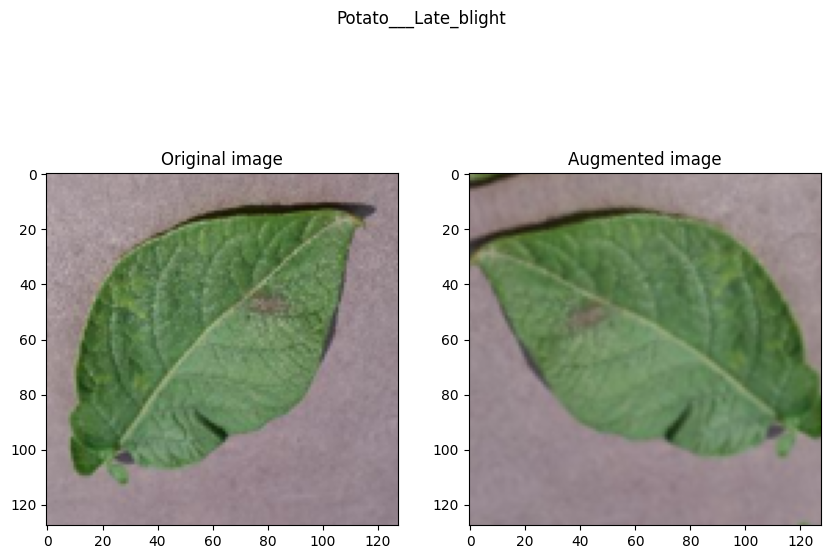

In [12]:
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

# Randomly choose a class from the list of classes
choiced_class = random.choice(classes)

# Construct the directory path for the chosen class
dir_path = Path(f'/kaggle/input/plant-village/PlantVillage/{choiced_class}')

# Get all image paths in the directory
all_images_pathes = dir_path.glob('*')

# Check if there are any images in the directory
if not all_images_pathes:
    raise ValueError('No images were found')  # Raise an error if no images are found

# Randomly choose an image path from the list
random_image_path = random.choice(list(all_images_pathes))

# Open and resize the chosen image
random_image = Image.open(random_image_path)
random_image = random_image.resize((128, 128))  # Resize the image to 128x128 pixels

# Convert the image to an array and normalize pixel values to [0, 1]
img_array = img_to_array(random_image) / 255

# Set up the plot
plt.figure(figsize=(10, 7))
plt.suptitle(choiced_class)  # Title of the plot showing the class name

# Plot the original image
plt.subplot(1, 2, 1)
plt.title('Original image')
plt.imshow(img_array)  # Display the original image

# Apply data augmentation to the image
augmented_image = data_augmentation(np.expand_dims(img_array, axis=0))

# Plot the augmented image
plt.subplot(1, 2, 2)
plt.title('Augmented image')
plt.imshow(np.squeeze(augmented_image))  # Display the augmented image

# Show the plot
plt.show()


In [116]:
# Measure the execution time of the training process
%%time

# Define early stopping to halt training if the model's performance does not improve for a specified number of epochs
early_stop = EarlyStopping(
    patience=15,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best validation loss
    verbose=1               # Verbosity mode, 1 will display messages when early stopping is triggered
)

# Train the CNN model
cnn_history = cnn_model.fit(
    train_data,             # Training data generator
    epochs=50,              # Number of epochs to train the model
    validation_data=test_data,  # Validation data generator to monitor performance during training
    batch_size=batch_size,  # Number of samples per gradient update
    callbacks=[early_stop]  # List of callbacks to apply during training, including early stopping
)


Epoch 1/50


2024-09-19 20:18:38.241986: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_23_1/dropout_51_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.5000 - loss: 0.9887 - val_accuracy: 0.7708 - val_loss: 0.6773
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7913 - loss: 0.5422 - val_accuracy: 0.8125 - val_loss: 0.5172
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8377 - loss: 0.4256 - val_accuracy: 0.9219 - val_loss: 0.2862
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8605 - loss: 0.3249 - val_accuracy: 0.9219 - val_loss: 0.2711
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8859 - loss: 0.2782 - val_accuracy: 0.9427 - val_loss: 0.2166
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9206 - loss: 0.2177 - val_accuracy: 0.9115 - val_loss: 0.2306
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9247 - loss: 0.1877 - val_accuracy: 0.9115 - val_loss: 0.2239
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9441 - loss: 0.1771 - val_accuracy: 0.9010 - val_loss: 0.

/tmp/ipykernel_36/1513561672.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', label='Training loss',color='red')
/tmp/ipykernel_36/1513561672.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, accuracy, 'b', label='Training accuracy',color='red')


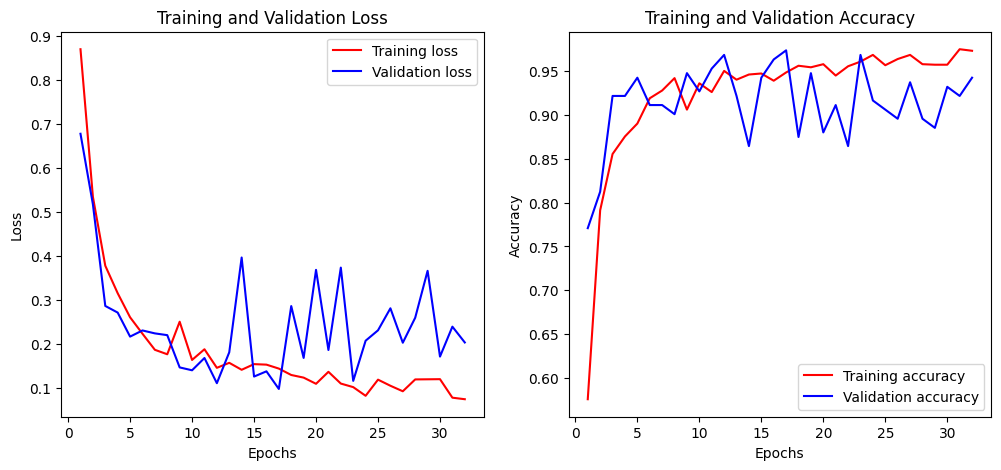

In [118]:
# function to plot loss and accuracy curves for model history 
def plot_loss_accuracy(history):
    """
    Plot training and validation loss and accuracy curves.
    
    Parameters:
    - history: Keras History object returned from model.fit()
    """
    # Extract values for loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss',color='red')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy',color='red')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
plot_loss_accuracy(cnn_history)

In [19]:
save_dir='/kaggle/working/models'
if not os.path.exists(save_dir): 
    os.makedirs(save_dir)
    
# saving cnn model    
cnn_model.save(f'{save_dir}/cnn_model.keras')

In [119]:
# loading and evaluating saved model
loaded_cnn_model=load_model(f'{save_dir}/cnn_model.keras')
loss,accuracy=loaded_cnn_model.evaluate(validation_data)
print(f'loss of loaded cnn model:\n{loss}')
print(f'accuracy of loaded cnn model:\n{accuracy}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9878 - loss: 0.0514
loss of loaded cnn model:
0.06339410692453384
accuracy of loaded cn model:
0.984375


In [21]:
steps = np.ceil(test_data.samples / test_data.batch_size).astype(int)

# Predict using the correct number of steps
y_scores = loaded_cnn_model.predict(validation_data, steps=steps)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [136]:
# 
print('count of classes in validation data\n')
validation_counts=Counter(validation_data.labels)
for i in range(3): 
    print(classes[i])
    print(validation_counts[i])
    print('#'*50)

count of classes in validation data

Potato___Early_blight
100
##################################################
Potato___Late_blight
100
##################################################
Potato___healthy
15
##################################################


In [23]:
y_pred=np.argmax(y_scores,axis=1)
y_test=validation_data.labels
print('classification report of cnn model predictions')
print(classification_report(y_test[:len(y_pred)],y_pred,target_names=classes))

                       precision    recall  f1-score   support

Potato___Early_blight       0.98      1.00      0.99        89
 Potato___Late_blight       0.99      0.98      0.98        91
     Potato___healthy       1.00      0.92      0.96        12

             accuracy                           0.98       192
            macro avg       0.99      0.96      0.98       192
         weighted avg       0.98      0.98      0.98       192



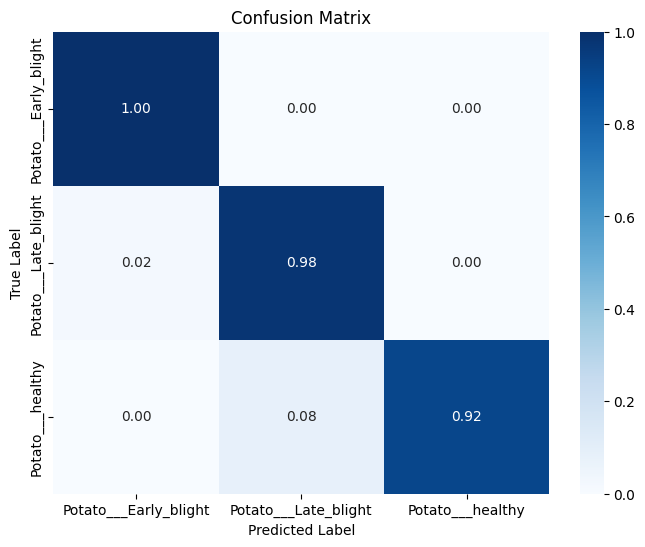

In [24]:
# function to visualize confusion matrix 
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plots a confusion matrix for a multi-class classification problem.
    
    Parameters:
    - y_true: true labels
    - y_pred: predicted labels
    - class_names: list of class names
    """
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize the confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    
    # Add labels and title
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Show the plot
    plt.show()
    
plot_confusion_matrix(y_test[:len(y_pred)],y_pred,classes)

Actual class:
 Potato___Early_blight
Predicted class:
 Potato___Early_blight


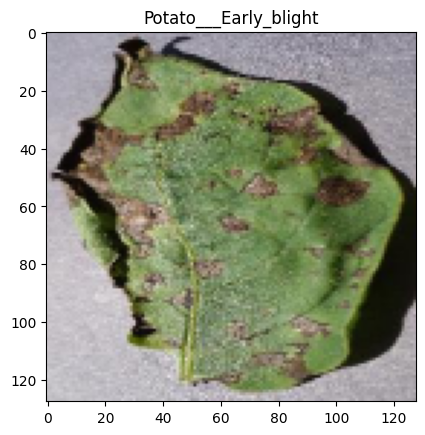

In [138]:

# Select a random class from the available classes
choiced_class = random.choice(classes)

# Construct the path to the directory containing images of the chosen class
dir_path = Path(f'/kaggle/input/plant-village/PlantVillage/{choiced_class}') 

# Retrieve all image file paths in the chosen class directory
all_images_pathes = dir_path.glob('*')

# Randomly select one image file path from the list
random_image_path = random.choice(list(all_images_pathes))

# Read the selected image using OpenCV
random_image = cv.imread(str(random_image_path))

# Resize the image to match the input size expected by the model
random_image = cv.resize(random_image, (128, 128))

# Convert the image from BGR (OpenCV default) to RGB
random_image = cv.cvtColor(random_image, cv.COLOR_BGR2RGB)

# Predict the class probabilities for the selected image
pred_scores = cnn_model.predict(np.expand_dims(random_image / 255, axis=0),verbose=0)

# Determine the class with the highest predicted probability
pred_label = classes[np.argmax(pred_scores, axis=1)[0]]

# Print the actual class and the predicted class
print(f'Actual class:\n {choiced_class}')
print(f'Predicted class:\n {pred_label}')

# Display the image
plt.title(choiced_class)
plt.imshow(random_image)

# Show the plot with the image
plt.show()

### Using pre-trained Resnet with only 20% of data 

#### Leveraging the Power of Transfer Learning

Transfer learning is a powerful technique in machine learning and deep learning that allows us to build high-performing models even with limited data. By using a pre-trained model as the starting point, we can leverage the knowledge learned from a large dataset and apply it to our specific task, often achieving remarkable results with significantly less data.

#### Case Study: ResNet with Limited Data

In this case study, we explore the application of transfer learning using a ResNet model, which was pre-trained on a large dataset and then fine-tuned on a much smaller subset of data—specifically, only 20% of the available dataset.

#### Why Transfer Learning?

Transfer learning offers several advantages:

- **Reduced Training Time**: Starting with a pre-trained model can drastically reduce the time required for training since the model has already learned useful features from a larger dataset.
- **Improved Performance**: Models pre-trained on large datasets often have better feature representations, which can lead to improved performance on smaller, specific datasets.
- **Efficiency**: Using a smaller subset of data for fine-tuning helps in cases where obtaining a large amount of labeled data is challenging or expensive.

#### Methodology

#### Pre-trained Model: ResNet

ResNet (Residual Networks) is a type of deep convolutional neural network known for its ability to train very deep networks effectively. It achieves this through the use of residual blocks that help in avoiding the vanishing gradient problem.

#### Fine-Tuning with Limited Data

1. **Dataset Preparation**: We used only 20% of the original dataset for fine-tuning the ResNet model. This smaller dataset is representative of the larger dataset and allows us to test the effectiveness of transfer learning with limited data.

2. **Model Training**: The ResNet model was first trained on the small dataset, utilizing pre-trained weights from a model that was trained on a larger dataset. This approach helps in adapting the model to our specific task while retaining the valuable features learned from the original training.

3. **Evaluation**: We evaluated the model’s performance using various metrics to ensure that it generalizes well to new data, despite being trained on a smaller subset.

#### Results

Training the ResNet model on only 20% of the data showed promising results. The model was able to achieve competitive performance metrics, demonstrating the effectiveness of transfer learning in leveraging pre-trained models for new tasks.

#### Conclusion

Transfer learning, especially with models like ResNet, allows us to achieve high performance even with a small amount of data. By starting with a pre-trained model and fine-tuning it on our specific dataset, we can save time, improve performance, and handle tasks with limited data more efficiently.

---

Leveraging the power of transfer learning can be a game-changer in many machine learning projects, making it a valuable technique in modern AI applications.


In [145]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in resnet.layers:
    layer.trainable = False

inputs=layers.Input(shape=(128,128,3),name='input_layer')
x=data_augmentation(inputs)
x=resnet(inputs)
# x = layers.BatchNormalization()(x)
x=Dropout(.5)(x)
x=Flatten()(x)
# x = layers.BatchNormalization()(x)
x=Dropout(.5)(x)
prediction = Dense(num_classes, activation='softmax',kernel_regularizer=l2(.01))(x)

# Create the model
resnet_model = Model(inputs=inputs, outputs=prediction)
resnet_model.summary()

Model: "functional_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 4, 4, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │        98,307 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,686,019 (90.35 MB)

 Trainable params: 98,307 (384.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [146]:
resnet_model.compile(loss=CategoricalCrossentropy(),optimizer=Adam(),metrics=['accuracy'])


In [147]:
class CustomDataGenerator(Sequence):
    def __init__(self, directory, classes, batch_size=32, target_size=(128, 128), shuffle=True, subset=None, data_fraction=1.0):
        self.directory = directory
        self.classes = classes
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.subset = subset  # 'training', 'validation', or 'testing'
        self.data_fraction = data_fraction  # Fraction of data to use
        
        # Collect all filenames and labels
        self.filenames, self.labels = self.collect_filenames_labels()

        # Apply data fraction
        if 0 < self.data_fraction < 1.0:
            self.filenames, self.labels = self.apply_data_fraction(self.data_fraction, self.filenames, self.labels)
        
        # Split data based on the subset
        self.filenames, self.labels = self.split_data()
        
        self.indexes = np.arange(len(self.filenames))
        self.samples = len(self.filenames)  # Total number of samples (images)
        
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
        # Debug information: Check collected data
        print(f"Subset: {self.subset}")
        print(f"Collected {len(self.filenames)} images for {self.subset}.")
        print(f"First 5 filenames: {self.filenames[:5]}")
        print(f"First 5 labels: {self.labels[:5]}")

    def collect_filenames_labels(self):
        """Collect filenames and their corresponding labels."""
        filenames = []
        labels = []
        
        # Check if the base directory exists
        if not os.path.exists(self.directory):
            raise ValueError(f"Base directory {self.directory} does not exist!")
        
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.directory, class_name)  # Directory for each class
            if os.path.exists(class_dir):
                class_files = os.listdir(class_dir)
                for filename in class_files:
                    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                        full_path = os.path.join(class_dir, filename)
                        filenames.append(full_path)  # Append full path
                        labels.append(class_idx)  # Append the class index
        return filenames, labels

    def apply_data_fraction(self, fraction, filenames, labels):
        """Apply the fraction to select a subset of the data."""
        unique_labels = np.unique(labels)
        selected_filenames = []
        selected_labels = []
        
        for label in unique_labels:
            class_filenames = [f for f, l in zip(filenames, labels) if l == label]
            n_samples = int(len(class_filenames) * fraction)
            selected_class_filenames = np.random.choice(class_filenames, n_samples, replace=False)
            selected_filenames.extend(selected_class_filenames)
            selected_labels.extend([label] * n_samples)
        
        return selected_filenames, selected_labels

    def split_data(self):
        """Split the data into training, validation, and testing subsets (80%/10%/10%)."""
        train_filenames, temp_filenames, train_labels, temp_labels = train_test_split(
            self.filenames, self.labels, test_size=0.2, stratify=self.labels, random_state=42)
        
        val_filenames, test_filenames, val_labels, test_labels = train_test_split(
            temp_filenames, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)
        
        if self.subset == 'training':
            return train_filenames, train_labels
        elif self.subset == 'validation':
            return val_filenames, val_labels
        elif self.subset == 'testing':
            return test_filenames, test_labels
        else:
            raise ValueError("Subset should be 'training', 'validation', or 'testing'")

    def __len__(self):
        """Number of batches per epoch."""
        return int(np.floor(len(self.filenames) / self.batch_size))
    
    def __getitem__(self, index):
        """Generate one batch of data."""
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_filenames = [self.filenames[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]
        
        # Preprocess the images
        X = np.zeros((len(batch_filenames), *self.target_size, 3))
        y = np.zeros((len(batch_filenames), len(self.classes)))
        
        for i, filename in enumerate(batch_filenames):
            image = load_img(filename, target_size=self.target_size)  # Load image
            image = img_to_array(image)  # Convert image to array
            image = preprocess_input(image)  # Preprocess image for ResNet50
            X[i] = image
            y[i, batch_labels[i]] = 1  # One-hot encoding for the label
        
        return X, y
    
    def on_epoch_end(self):
        """Shuffle indexes after each epoch.""" 
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
train_data = CustomDataGenerator(directory=data_dir, classes=classes,
                                 batch_size=batch_size, target_size=img_size, subset='training', shuffle=True,data_fraction=.2)
validation_data = CustomDataGenerator(directory=data_dir, classes=classes, 
                                      batch_size=batch_size, target_size=img_size, subset='validation', shuffle=False,data_fraction=1)
test_data = CustomDataGenerator(directory=data_dir, classes=classes,
                                batch_size=batch_size, target_size=img_size, subset='testing', shuffle=False,data_fraction=1)  


Subset: training
Collected 344 images for training.
First 5 filenames: ['/kaggle/input/plant-village/PlantVillage/Potato___Early_blight/21d50c27-900e-4644-ab01-0cc96214d2f6___RS_Early.B 7153.JPG', '/kaggle/input/plant-village/PlantVillage/Potato___Early_blight/a02f78b3-da52-400a-ab11-7184df9ea485___RS_Early.B 8403.JPG', '/kaggle/input/plant-village/PlantVillage/Potato___Late_blight/4f249e3b-92a0-43e5-a70d-fe3045630437___RS_LB 3913.JPG', '/kaggle/input/plant-village/PlantVillage/Potato___Early_blight/ee584747-fea1-4d16-9c03-40bfc9bcf1c7___RS_Early.B 8600.JPG', '/kaggle/input/plant-village/PlantVillage/Potato___Early_blight/8c01f338-2648-4bcf-99cb-853978b39014___RS_Early.B 6742.JPG']
First 5 labels: [0, 0, 1, 0, 0]
Subset: validation
Collected 215 images for validation.
First 5 filenames: ['/kaggle/input/plant-village/PlantVillage/Potato___Early_blight/2d149f7a-4b0a-40a6-8d0b-1d1f14e5e696___RS_Early.B 9143.JPG', '/kaggle/input/plant-village/PlantVillage/Potato___Late_blight/37dbf454-f189

In [148]:

# Define a callback to reduce the learning rate when the metric plateaus
reduce_lr = ReduceLROnPlateau(
    factor=0.5,                # Factor by which to reduce the learning rate
    min_lr=1e-6,              # Minimum learning rate to which it can be reduced
    verbose=1,                # Verbosity mode (0 or 1). If 1, prints messages when the learning rate is reduced
    patience=5                # Number of epochs to wait for improvement before reducing the learning rate
)

# Define a callback to stop training early when a monitored metric has stopped improving
early_stop = EarlyStopping(
    patience=15,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True, # Whether to restore model weights from the epoch with the best value of the monitored metric
    verbose=1                 # Verbosity mode (0 or 1). If 1, prints messages when stopping the training
)

# Train the ResNet model
resnet_history = resnet_model.fit(
    train_data,                # Training data generator
    epochs=50,                 # Number of epochs to train the model
    validation_data=test_data, # Validation data generator to evaluate the model after each epoch
    batch_size=batch_size,     # Batch size used for training
    callbacks=[early_stop]  # List of callbacks to apply during training
)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 476ms/step - accuracy: 0.5317 - loss: 4.2466 - val_accuracy: 0.8958 - val_loss: 1.8958
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8769 - loss: 1.2885 - val_accuracy: 0.9115 - val_loss: 0.7469
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9024 - loss: 0.8445 - val_accuracy: 0.9531 - val_loss: 0.1982
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9561 - loss: 0.2429 - val_accuracy: 0.9583 - val_loss: 0.2423
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9600 - loss: 0.3518 - val_accuracy: 0.9792 - val_loss: 0.1717
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9970 - loss: 0.0792 - val_accuracy: 0.9688 - val_loss: 0.1770
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9917 - loss: 0.0949 - val_accuracy: 0.9792 - val_loss: 0.1521
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9859 - loss: 0.1324 - val_accuracy: 0.9792 - val_loss: 

/tmp/ipykernel_36/1513561672.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', label='Training loss',color='red')
/tmp/ipykernel_36/1513561672.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, accuracy, 'b', label='Training accuracy',color='red')


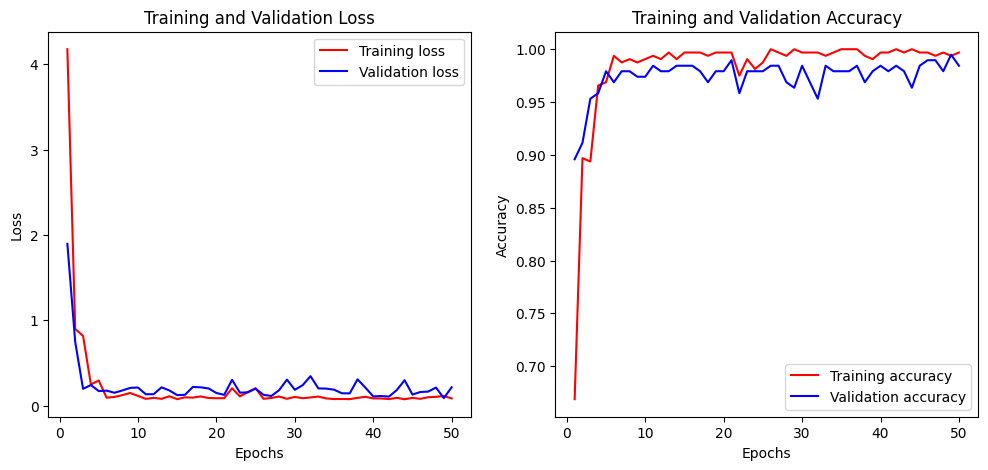

In [149]:
plot_loss_accuracy(resnet_history)

In [150]:
# evaluating resnet model on validation data 
resnet_model.evaluate(validation_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9932 - loss: 0.0947


[0.12406950443983078, 0.9791666865348816]

In [153]:
# Get the true labels for the validation dataset
y_test_2 = validation_data.labels

# Predict the class probabilities for the validation dataset using the trained ResNet model
y_scores_2 = resnet_model.predict(validation_data,verbose=0)

# Convert the class probabilities to predicted class labels by choosing the class with the highest probability
y_pred_2 = np.argmax(y_scores_2, axis=1)

# This is necessary if the full validation dataset is larger than the number of predictions
print(classification_report(y_test_2[:len(y_pred_2)], y_pred_2))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        89
           1       0.99      0.97      0.98        91
           2       0.92      0.92      0.92        12

    accuracy                           0.98       192
   macro avg       0.96      0.96      0.96       192
weighted avg       0.98      0.98      0.98       192



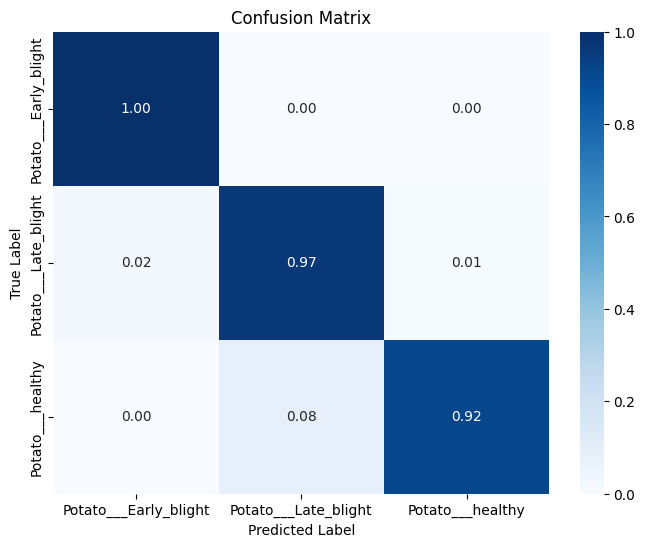

In [154]:
# confusion matrix of resnet model predictions 
plot_confusion_matrix(y_test_2[:len(y_pred_2)], y_pred_2,class_names=classes)